In [1]:
import numpy as np 
import pandas as pd
from sklearn.model_selection import cross_val_score, GridSearchCV, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, plot_precision_recall_curve, plot_roc_curve
from sklearn.ensemble import RandomForestClassifier

In [2]:
data = pd.read_csv('../input/pre-rand-forest/rand_forest.csv')
data.drop('Unnamed: 0', axis=1, inplace=True)
data.head()

,dist_from_off,playId,gameId,nflId,frameId,off_nflId,displayName,nearest_is_target,distanceFromBall.x,off_distanceFromBall,...,avg_speed_diff,pct_first_off,pct_last_off,last_off,first_off,var_look_at_qb,dist_los,complete,covering_target,covering_first_off
0,4.160048,75,2018090600,2555383,36,2495454,Jalen Mills,1,27.156924,24.178662,...,-1.159231,1.000000,1.000000,2495454,2495454,0.00000,6.19,1,1,1
1,4.687569,146,2018090600,2555383,31,2560854,Jalen Mills,1,16.225024,11.622517,...,-1.004286,1.000000,1.000000,2560854,2560854,0.00000,7.56,0,1,1
2,4.243218,190,2018090600,79848,39,2495454,Malcolm Jenkins,1,19.235930,23.477012,...,-2.902759,1.000000,1.000000,2495454,2495454,0.00000,4.31,1,1,1
3,3.989010,320,2018090600,2539653,29,2552600,Robert Alford,1,17.720553,14.546017,...,-1.560526,0.157895,0.842105,2552600,2540158,0.22807,3.89,1,1,0
4,2.144108,344,2018090600,2543850,34,2506467,Ricardo Allen,1,17.089798,15.135283,...,-2.086667,0.458333,0.541667,2506467,2507763,0.11413,6.76,0,1,0


In [3]:
data.columns

Index(['dist_from_off', 'playId', 'gameId', 'nflId', 'frameId', 'off_nflId',
       'displayName', 'nearest_is_target', 'distanceFromBall.x',
       'off_distanceFromBall', 'ball_behind_db', 'diff_in_speed',
       'diff_in_acceleration', 'diff_in_dir', 'receiver_behind_db',
       'receiver_distance_from_qb', 'num_of_receivers_nearest',
       'dist_rate_of_change', 'his_off_most_open', 'passResult', 'targetNflId',
       'x', 'y', 'o', 'dir', 's', 'a', 'event', 'epa', 'position', 'route',
       'isDefensivePI', 'targetedReceiver', 'team_name', 'ball_x', 'ball_y',
       'ball_snap_x', 'max_space_available', 'target_x', 'target_y', 'qb_x',
       'qb_y', 'qb_s', 'qb_a', 'distanceFromBall.y', 'distanceFromTarget',
       'distance_from_qb', 'snap_to_throw', 'var_xs', 'var_ys', 'var_o',
       'avg_speed', 'var_speed', 'look_at_qb', 'avg_dist', 'var_dist',
       'avg_dir_diff', 'avg_speed_diff', 'pct_first_off', 'pct_last_off',
       'last_off', 'first_off', 'var_look_at_qb', 'dist_l

In [4]:
data = data[['complete', 'isDefensivePI', 'dist_from_off', 'dist_los', 'passResult',
             'qb_s', 'qb_a', 'max_space_available', 'distance_from_qb', 'receiver_distance_from_qb',
             'ball_behind_db', 'diff_in_speed', 'diff_in_acceleration', 'diff_in_dir',
             'his_off_most_open', 'receiver_behind_db', 'dist_rate_of_change',
             'gameId', 'playId', 'frameId', 'off_nflId', 'nflId', 'displayName', 'event']]
data = data[(data.isDefensivePI != True) & (data.passResult != 'S')]

# holding_data.to_csv('holding_data.csv')

data.dropna(inplace=True)
data.reset_index(inplace=True)

holding_data = data[['gameId', 'playId', 'frameId', 'off_nflId', 'nflId', 'displayName', 'event']]

data.head()

,index,complete,isDefensivePI,dist_from_off,dist_los,passResult,qb_s,qb_a,max_space_available,distance_from_qb,...,his_off_most_open,receiver_behind_db,dist_rate_of_change,gameId,playId,frameId,off_nflId,nflId,displayName,event
0,0,1,False,4.160048,6.19,C,0.84,2.05,90.11,26.933854,...,0.0,4.16,0.077024,2018090600,75,36,2495454,2555383,Jalen Mills,pass_forward
1,1,0,False,4.687569,7.56,I,0.46,2.25,49.17,15.607181,...,0.0,4.23,-0.237617,2018090600,146,31,2560854,2555383,Jalen Mills,pass_forward
2,2,1,False,4.243218,4.31,C,2.38,0.91,50.00,18.825995,...,0.0,-4.07,0.912738,2018090600,190,39,2495454,79848,Malcolm Jenkins,pass_forward
3,3,1,False,3.989010,3.89,C,1.15,1.57,106.69,17.422873,...,0.0,3.91,-0.188624,2018090600,320,29,2552600,2539653,Robert Alford,pass_forward
4,4,0,False,2.144108,6.76,I,1.02,0.81,103.16,16.891823,...,0.0,2.04,-0.380287,2018090600,344,34,2506467,2543850,Ricardo Allen,pass_forward


In [5]:
y_data = np.array(data['complete'])
x_data = data.drop(['complete', 'index', "isDefensivePI", 'passResult',
                   'gameId', 'playId', 'frameId', 'off_nflId', 'nflId', 'displayName', 'event'], axis = 1)

In [6]:
x_data.head()

,dist_from_off,dist_los,qb_s,qb_a,max_space_available,distance_from_qb,receiver_distance_from_qb,ball_behind_db,diff_in_speed,diff_in_acceleration,diff_in_dir,his_off_most_open,receiver_behind_db,dist_rate_of_change
0,4.160048,6.19,0.84,2.05,90.11,26.933854,24.009259,0.0,1.57,-4.49,20.40,0.0,4.16,0.077024
1,4.687569,7.56,0.46,2.25,49.17,15.607181,11.034174,0.0,0.91,2.42,129.71,0.0,4.23,-0.237617
2,4.243218,4.31,2.38,0.91,50.00,18.825995,23.063187,0.0,-6.18,0.31,86.32,0.0,-4.07,0.912738
3,3.989010,3.89,1.15,1.57,106.69,17.422873,14.197003,0.0,-2.51,0.26,27.11,0.0,3.91,-0.188624
4,2.144108,6.76,1.02,0.81,103.16,16.891823,14.908363,0.0,-2.39,-1.70,310.64,0.0,2.04,-0.380287


In [7]:
def trainSets(x_data,y_data):
    # args: pandas dataframe, pandas dataframe
    # return: pandas dataframe, pandas dataframe, pandas series, pandas series
    x_train, x_test, y_train, y_test = train_test_split(
        x_data, y_data,
        test_size=0.15, train_size=.85,
        random_state=614, shuffle=True)
    return x_train, x_test, y_train, y_test
model_data = trainSets(x_data, y_data)

In [8]:
class RFClassifier():
    def randomForestClassifier(self,x_train, x_test, y_train):
        # args: pandas dataframe, pandas dataframe, pandas series
        # return: RandomForestClassifier object, numpy array, numpy array
        rf_clf = RandomForestClassifier(random_state=614,
                                        max_depth = 20,
                                        max_features = 'auto',
                                        min_samples_leaf = 2,
                                        min_samples_split = 10,
                                        n_estimators = 200)
        rf_clf.fit(x_train, y_train)
        y_predict_train = rf_clf.predict(x_train)
        y_predict_train = np.array(y_predict_train)
        y_predict_test = rf_clf.predict(x_test)
        y_predict_test = np.array(y_predict_test)
        
        return rf_clf, y_predict_train, y_predict_test
    
    def rfTrainAccuracy(self,y_train,y_predict_train):
        # args: pandas series, numpy array
        # return: float
        y_predict_train = np.rint(y_predict_train)
        train_accuracy = accuracy_score(y_train, y_predict_train)
        return train_accuracy
    
    def rfTestAccuracy(self,y_test,y_predict_test):
        # args: pandas series, numpy array
        # return: float
        y_predict_test = np.rint(y_predict_test)
        test_accuracy = accuracy_score(y_test, y_predict_test)
        return test_accuracy

    def rfFeatureImportance(self,rf_clf):
        # args: RandomForestClassifier object
        # return: float array
        feature_importance = rf_clf.feature_importances_
        # std = np.std([tree.feature_importances_ for tree in rf_clf.estimators_],
        #      axis=0)
        # indices = np.argsort(importances)[::-1]
        return feature_importance
    
    def sortedRFFeatureImportanceIndicies(self,rf_clf):
        # args: RandomForestClassifier object
        # return: int array
        importances = rf_clf.feature_importances_

        sorted_indices = np.argsort(importances)[::-1]
        # -------------------------------
        return sorted_indices
    
    def hyperParameterTuning(self,rf_clf,x_train,y_train):
        # args: RandomForestClassifier object, pandas dataframe, pandas series
        # return: GridSearchCV object
        parameters = {'max_depth': [5, 10, 20, 30],
                      'max_features': ['auto', 'sqrt'],
                      'min_samples_leaf': [1, 2, 4],
                      'min_samples_split': [2, 5, 10],
                      'n_estimators': [50, 100, 200, 250, 400]}
        gscv_rfc = GridSearchCV(rf_clf, parameters)
        gscv_rfc.fit(x_train, y_train)
        return gscv_rfc
    
    def bestParams(self,gscv_rfc):
        # args:  GridSearchCV object
        # return: parameter dict
        best_params = gscv_rfc.best_params_
        return best_params
    
    def bestScore(self,gscv_rfc):
        # args: GridSearchCV object
        # return: float
        best_score = gscv_rfc.best_score_
        return best_score

In [9]:
train_x = model_data[0]
test_x = model_data[1]
train_y = model_data[2]
test_y = model_data[3]

In [10]:
rf = RFClassifier()
model = rf.randomForestClassifier(train_x, test_x, train_y)
pred_y_train = model[1]
pred_y_test = model[2]
model = model[0]

print("Train Acc:")
print(rf.rfTrainAccuracy(train_y, pred_y_train))
print("Test Acc:")
print(rf.rfTestAccuracy(test_y, pred_y_test))
print('Recall:')
print(recall_score(test_y, pred_y_test))
print('Precision:')
print(precision_score(test_y, pred_y_test))
print('F1 Score:')
print(f1_score(test_y, pred_y_test))


print("Feature Importance: ") 
print(rf.rfFeatureImportance(model))

print("Sorted Indices:")
print(rf.sortedRFFeatureImportanceIndicies(model))

# gridCV = rf.hyperParameterTuning(model, train_x, train_y)

# print("Best Params:")
# print(rf.bestParams(gridCV))
# best_params = rf.bestParams(gridCV)

# print("Best Score:")
# print(rf.bestScore(gridCV))

# best params: {'max_depth': 20, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 200}

Train Acc:
0.9547285632073662
Test Acc:
0.7576086956521739
Recall:
0.8360975609756097
Precision:
0.7550660792951542
F1 Score:
0.7935185185185186
Feature Importance: 
[0.13917829 0.07313586 0.06832649 0.05560566 0.08087728 0.07182111
 0.08411435 0.00039031 0.06825963 0.06630396 0.08467724 0.00279306
 0.10413997 0.1003768 ]
Sorted Indices:
[ 0 12 13 10  6  4  1  5  2  8  9  3 11  7]


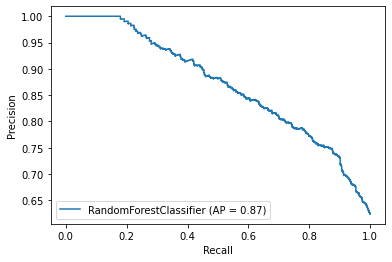

In [11]:
plot_precision_recall_curve(model, test_x, test_y)

[Text(0, 0, 'dist_from_off'),
 Text(0, 0, 'dist_los'),
 Text(0, 0, 'qb_s'),
 Text(0, 0, 'qb_a'),
 Text(0, 0, 'max_space_available'),
 Text(0, 0, 'distance_from_qb'),
 Text(0, 0, 'receiver_distance_from_qb'),
 Text(0, 0, 'ball_behind_db'),
 Text(0, 0, 'diff_in_speed'),
 Text(0, 0, 'diff_in_acceleration'),
 Text(0, 0, 'diff_in_dir'),
 Text(0, 0, 'his_off_most_open'),
 Text(0, 0, 'receiver_behind_db'),
 Text(0, 0, 'dist_rate_of_change')]

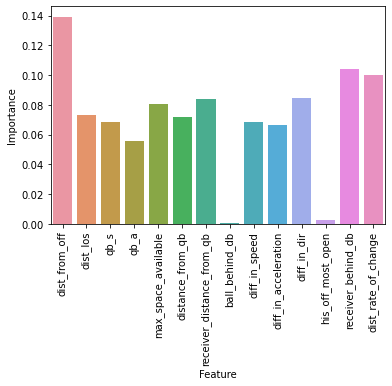

In [12]:
feat_imp = pd.DataFrame(train_x.columns, rf.rfFeatureImportance(model)).reset_index()
feat_imp.columns = ['Importance', 'Feature']

import seaborn as sns
import matplotlib.pyplot as plt

g = sns.barplot(x="Feature", y="Importance", data=feat_imp)
g.set_xticklabels(g.get_xticklabels(), rotation=90)

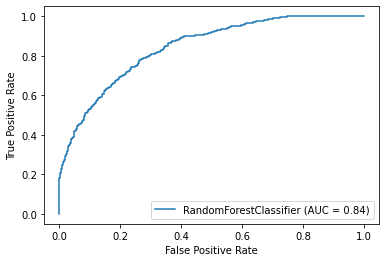

In [13]:
plot_roc_curve(model, test_x, test_y)

In [14]:
pred_data = pd.read_csv('../input/pre-rand-forest/rf_pred.csv')
pred_data.dropna(inplace=True)
pred_data.head()
pred_data.shape

(3510738, 22)

In [15]:
holding_data = pred_data[['gameId', 'playId', 'frameId', 'off_nflId', 'nflId', 'displayName', 'event']]
holding_data.event.unique()

array(['ball_snap', 'None', 'pass_forward', 'pass_arrived',
       'pass_outcome_incomplete', 'play_action', 'pass_tipped',
       'pass_outcome_interception', 'line_set', 'penalty_flag',
       'penalty_accepted', 'man_in_motion', 'shift', 'run_pass_option',
       'first_contact', 'pass_outcome_touchdown', 'fumble',
       'fumble_offense_recovered', 'pass_outcome_caught',
       'huddle_start_offense'], dtype=object)

In [16]:
pred_data = pred_data.drop(['gameId', 'playId', 'frameId', 'off_nflId', 'nflId', 'displayName', 'event', 'Unnamed: 0'],
                           axis=1)
pred_data.head()

,dist_from_off,dist_los,qb_s,qb_a,max_space_available,distance_from_qb,receiver_distance_from_qb,ball_behind_db,diff_in_speed,diff_in_acceleration,diff_in_dir,his_off_most_open,receiver_behind_db,dist_rate_of_change
0,1.920339,1.22,0.00,0.00,90.11,10.234813,9.538433,0.0,0.01,0.01,258.48,0.0,1.89,0.000000
1,1.922134,1.22,0.00,0.00,90.11,10.240400,9.530519,0.0,0.01,0.01,276.29,0.0,1.89,0.000000
2,1.912302,1.22,0.03,0.82,90.11,10.246024,9.533651,0.0,-0.02,-0.29,280.46,0.0,1.88,0.000000
3,1.908743,1.22,0.22,2.24,90.11,10.239258,9.544658,0.0,-0.07,-0.50,34.84,0.0,1.88,-0.006038
4,1.889047,1.22,0.61,3.46,90.11,10.265988,9.563472,0.0,-0.22,-1.20,9.95,0.0,1.86,-0.017214


In [17]:
comp_prob = model.predict_proba(pred_data)
comp_prob[:5]

array([[0.27735734, 0.72264266],
       [0.28235734, 0.71764266],
       [0.27246084, 0.72753916],
       [0.24413144, 0.75586856],
       [0.32275737, 0.67724263]])

In [18]:
comp_prob = [x[1] for x in comp_prob]
pred_data['comp_prob'] = comp_prob

In [19]:
comp_prob_dat = pd.concat([holding_data, pred_data], axis=1)

comp_prob_dat.to_csv('comp_prob_dat.csv')

In [20]:
# holding_data.shape